In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, mean_squared_error
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report
from sklearn.utils import resample
from catboost import CatBoostClassifier, Pool
import optuna

In [4]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [5]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [6]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [7]:
# Replace empty strings or spaces with NaN
df['TotalCharges'] = df['TotalCharges'].replace(r'^\s*$', np.nan, regex=True)

# Now safely convert to float
df['TotalCharges'] = df['TotalCharges'].astype(float)

# Feature Description

**1. Demographic / Personal Attributes**

**gender**: Male or Female

**SeniorCitizen**: Binary flag (1 if age > 60; else 0)

**Partner**: Yes/No — whether customer has a partner

**Dependents**: Yes/No — dependent children or parents 

**2. Account & Billing Details**

**tenure**: Number of months the customer has stayed (0–72)

**MonthlyCharges**: Recurring monthly charges

**TotalChargesv**: Sum of all charges over tenure period 


**3. Service Subscriptions**

Binary or multi-value indicators of services:

**PhoneService**: Yes/No

**MultipleLines**: Yes/No/No phone service

**InternetService**: DSL, Fiber optic, or No

OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies: Yes/No or “No Internet Service” 

**4. Contract & Payment Information**

**Contract**: Month-to-month, One year, Two year

**PaperlessBilling**: Yes/No

**PaymentMethod**: e.g., Electronic check, Mailed check, Bank transfer, Credit card 


**5. Target**
**Churn**: Whether the customer churned (Yes or No) — the prediction target variable 

# Data Profiling

In [6]:
profile = ProfileReport(df)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████████████████████████████████████| 21/21 [00:00<00:00, 227.92it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Profiling observations

**1. Dataset Overview**
- The dataset contains 7,043 rows and 21 columns.

**2. Target Variable: 'Churn'**
- Distribution is imbalanced:
  - No: ~73%
  - Yes: ~27%
- Consider stratified sampling and evaluation metrics like F1-score or AUC.

**3. Features**
- 'tenure' is has strong modes at 0 and 72 months.
- 'MonthlyCharges' has a strong model for the monthlly payment values and then distrbuted value from 40 to 120.
- 'TotalCharges' is highly correlated with 'tenure' but contains invalid entries and needs cleaning.
- We have more non-senior customers, 5:1.
- Customers with and without patters have similar numbers
- Most customers do not have dependents.
- Most contrats are month-to-month which may be the reaso for higher churn
- total charges are highly skewed towards zero
- Most customers never called to support but still there are many support complaints.
- General observations is that most features are skewed and not evenly distributed between feature classes.
- To get an understanding how these skewnesses are relqted to target, let's look into it.

# Feature target relationships

In [7]:
# Ensure 'Churn' is binary
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
df.drop(columns=['customerID'], inplace=True)

# Separate categorical and numeric columns
cat_cols = df.select_dtypes(include='object').columns.tolist()
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
num_cols = [col for col in num_cols if col != 'Churn']

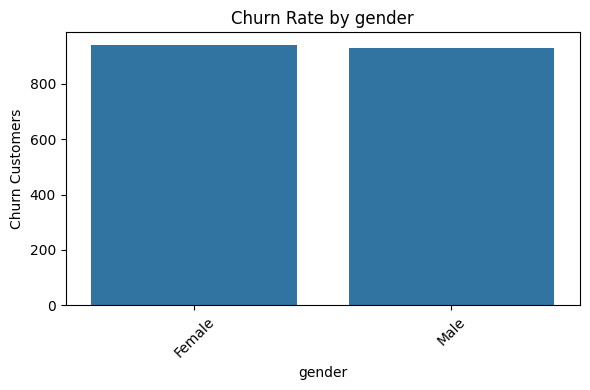

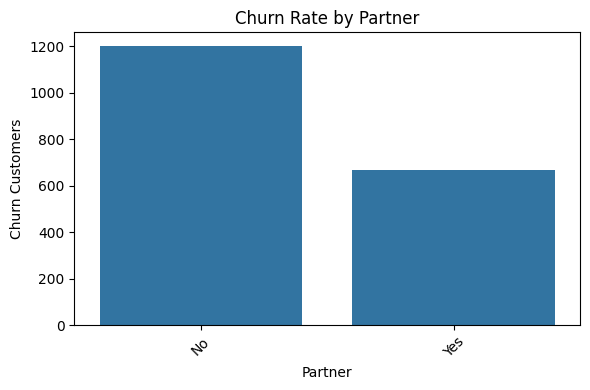

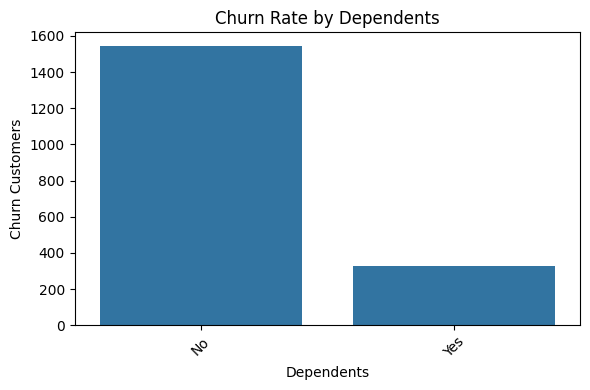

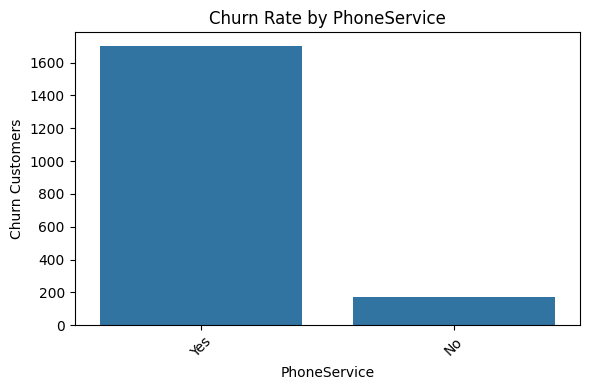

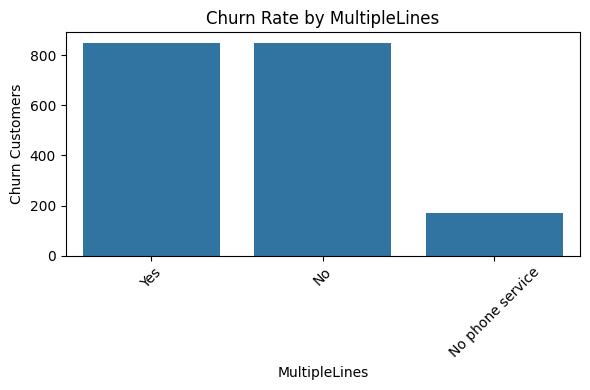

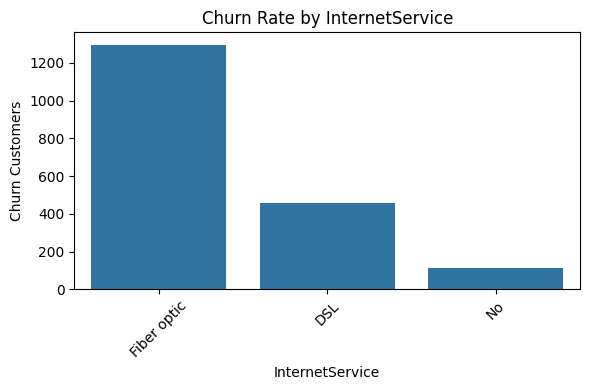

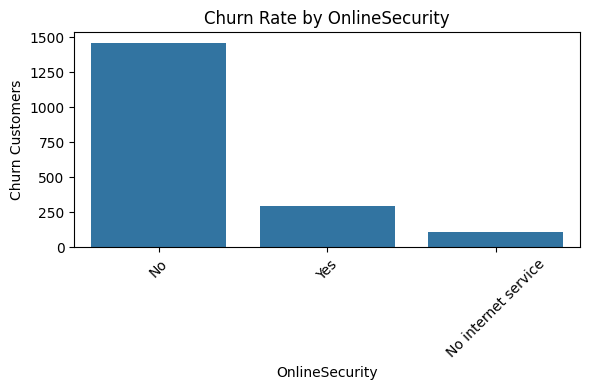

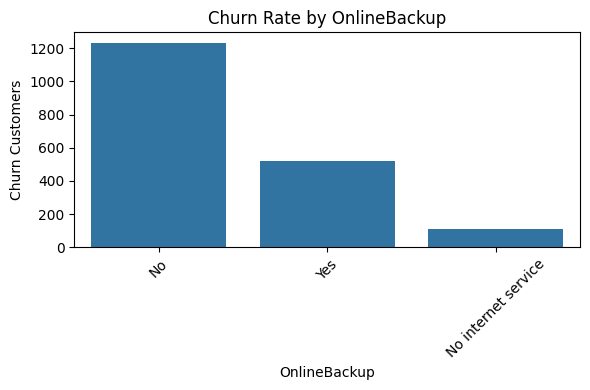

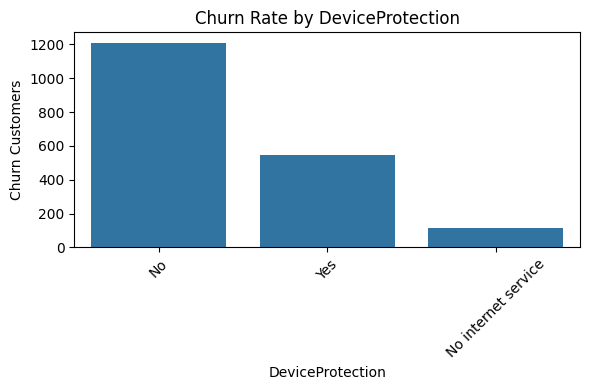

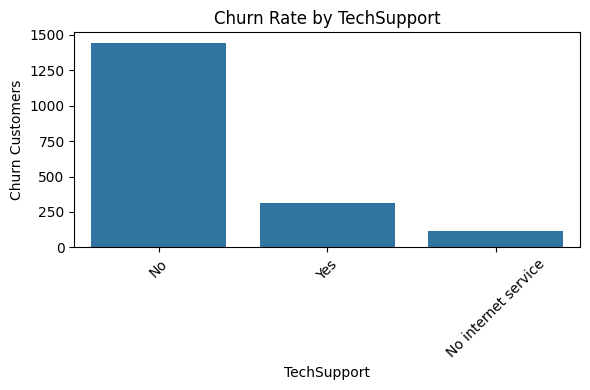

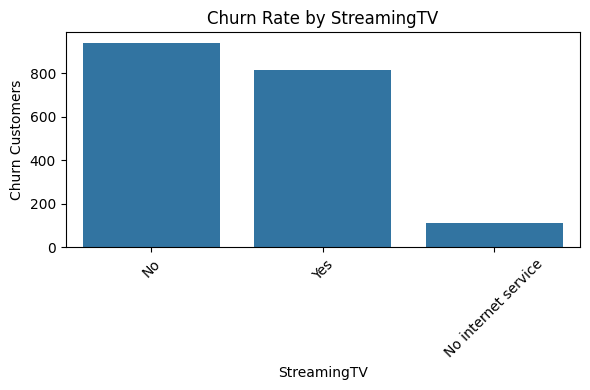

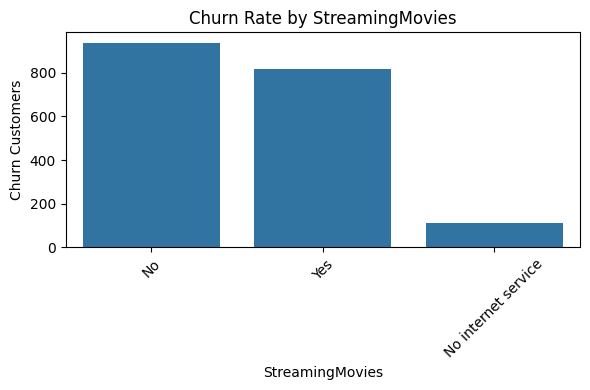

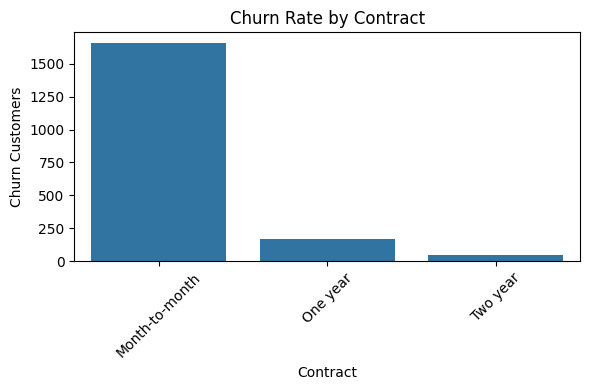

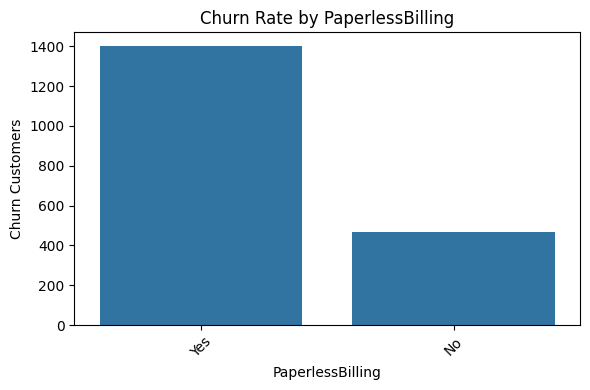

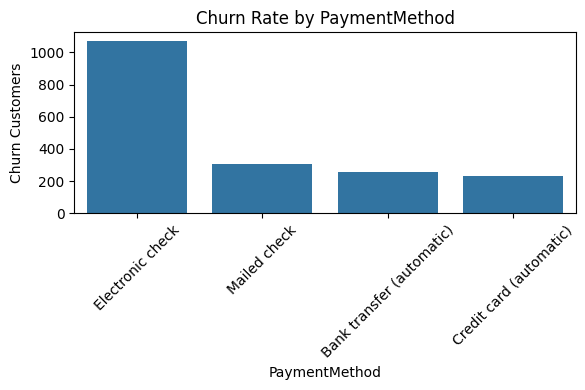

In [8]:
%matplotlib inline

for col in cat_cols:
    plt.figure(figsize=(6, 4))
    churn_pct = df.groupby(col)['Churn'].sum().sort_values(ascending=False)
    sns.barplot(x=churn_pct.index, y=churn_pct.values)
    plt.title(f'Churn Rate by {col}')
    plt.ylabel('Churn Customers')
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    plt.close()

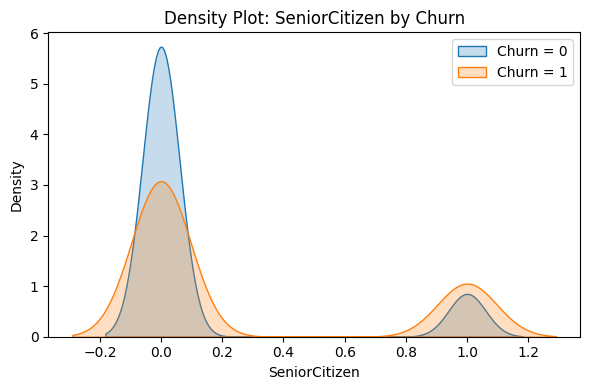

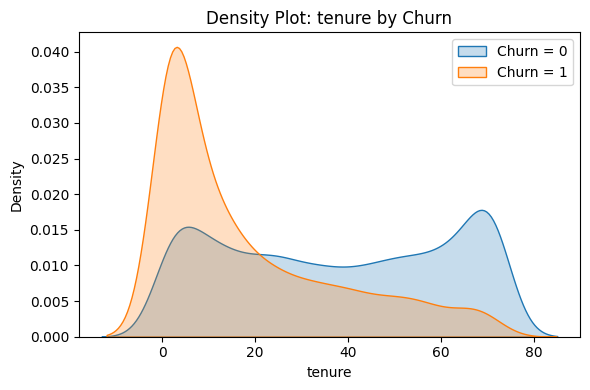

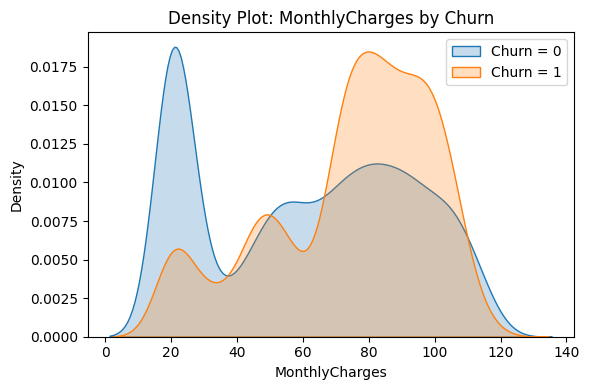

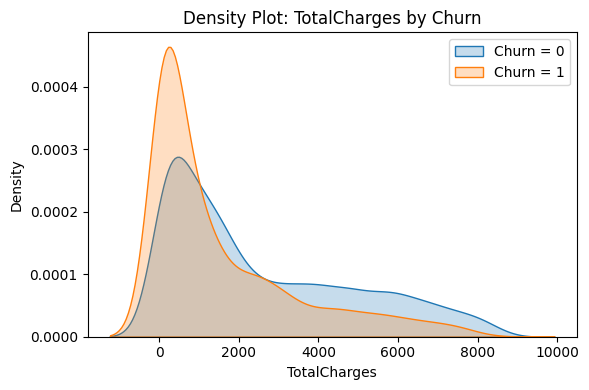

In [9]:
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(df[df['Churn'] == 0][col], label='Churn = 0', fill=True)
    sns.kdeplot(df[df['Churn'] == 1][col], label='Churn = 1', fill=True)
    plt.title(f'Density Plot: {col} by Churn')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()

## Churn Analysis by Feature

This analysis is based on bar plots showing the **number of churned customers** per category for each feature.

---

### 1. Gender
- Churned customer counts are nearly the same between **male** and **female**.
- **Insight**: Gender has no impact on churn likelihood.

### 2. Partner
- Customers **without a partner** show more churn.
- **Insight**: Having a partner may correlate with life stability and lower churn risk.

### 3. Dependents
- Customers **without dependents** churn far more.
- **Insight**: Customers with dependents tend to be more stable or committed.

### 4. PhoneService
- The vast majority of churned customers had **phone service**.
- **Insight**: Phone service alone doesn't prevent churn. Lack of phone service likely means minimal engagement.

### 5. MultipleLines
- Similar churn counts for `Yes` and `No`.
- **Insight**: Having multiple phone lines is not strongly related to churn.

### 6. InternetService
- Churn is highest for **fiber optic** users, lower for **DSL**, and lowest for customers with **no internet service**.
- **Insight**: Fiber users may be more demanding or sensitive to performance and pricing.

### 7. OnlineSecurity
- Customers without online security churn far more than those who have it.
- **Insight**: This is a strong indicator of engagement and loyalty.

### 8. OnlineBackup
- Similar to OnlineSecurity: churn is higher when this service is missing.
- **Insight**: Backup services are another strong retention factor.

### 9. DeviceProtection
- Customers without protection churn the most.
- **Insight**: Engaged users tend to opt in to protective services and are less likely to leave.

### 10. TechSupport
- Very high churn among customers with no tech support.
- **Insight**: Providing tech support can significantly reduce churn.

### 11. StreamingTV
- Churn is only slightly higher for `No` compared to `Yes`.
- **Insight**: StreamingTV alone is not a strong churn predictor.

### 12. StreamingMovies
- Same pattern as StreamingTV.
- **Insight**: Streaming services are weak predictors of churn when compared to support or security features.

### 13. Contract
- Customers with **month-to-month** contracts dominate churn.
- Those on **1-year** or **2-year** contracts churn much less.
- **Insight**: Long-term contracts are the most powerful churn-reducing factor.

### 14. PaperlessBilling
- Much higher churn for customers with paperless billing.
- **Insight**: These users may be more cost-sensitive or quicker to cancel.

### 15. PaymentMethod
- Highest churn comes from **electronic check** users.
- Other methods (credit card, bank transfer, mailed check) have much lower churn.
- **Insight**: Electronic check usage is a strong churn signal.

### 16. TotalCharges
- Plot appears distorted due to many unique values and poor binning.
- **Insight**: This chart is not meaningful in current form. Suggest using boxplots or histograms grouped by Churn.
- 

## Distribution Insights: Numeric Features by Churn

The plots below show **KDE (density) distributions** for each numeric feature, split by churn status (`Churn = 0` vs `Churn = 1`).

---

### 1. SeniorCitizen
- Two distinct peaks: one at 0 (non-senior) and one at 1 (senior).
- The **churn distribution is slightly higher for senior citizens** (orange peak at 1 is slightly taller).
- **Insight**: Being a senior is associated with a slightly higher churn likelihood, but not a dominant factor.

---

### 2. Tenure
- **Churned customers** are heavily concentrated around **short tenures** (0–12 months).
- **Non-churned customers** show a broader, more even distribution, with a noticeable peak at high tenure values (~60+ months).
- **Insight**: Tenure is a strong predictor of churn — newer customers are much more likely to leave.

---

### 3. MonthlyCharges
- **Churned customers** tend to have **higher monthly charges**, with a peak around 80–90.
- **Non-churned customers** show a bimodal distribution — some pay very little, others around 70–80.
- **Insight**: Higher monthly charges are associated with increased churn risk, especially when not accompanied by long tenure or bundled services.

---

### Summary
- **Strong churn signal**: Low tenure and high monthly charges.
- **Moderate churn signal**: Senior status.
- These patterns confirm that churn is often driven by newer, high-paying customers who may not yet perceive enough value to stay.


---

## Overall Insights

- **Strongest churn indicators**:
  - Contract type (especially month-to-month)
  - Payment method (electronic check)
  - Lack of tech-related services: OnlineSecurity, TechSupport, DeviceProtection, OnlineBackup
- **Moderate predictors**:
  - Internet service type (fiber optic users churn more)
  - Paperless billing (associated with higher churn)
  - Household situation (no partner or dependents → higher churn)
- **Weak or no correlation**:
  - Gender
  - Streaming services (StreamingTV, StreamingMovies)
  - Multiple phone lines

These patterns suggest that **churn is driven more by contract flexibility, service engagement, and billing preferences than by demographic attributes**.

**To reduce churn:**
- Encourage long-term contracts
- Bundle value-added services like security and support
- Offer incentives for more stable payment methods


# Preprocessing

In [8]:
df[df['tenure'] == 0].index

Index([488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754], dtype='int64')

These values are irrelevant since it essentially means that the users never used the service, so we can remove it

In [9]:
df.drop(labels=df[df['tenure'] == 0].index, axis=0, inplace=True)
df[df['tenure'] == 0].index

Index([], dtype='int64')

In [10]:
# Check for Nan values
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

# Feature Engineering

For this dataset, we will use tree-based models, which allow us using LabelEncoder instaler of One-Hot Endcoding to reduce sparsity.

In [11]:
def encode_features(df: pd.DataFrame):
    if df.dtype=='object':
        encoder = LabelEncoder()
        df = encoder.fit_transform(df)
    return df

In [12]:
df = df.apply(lambda x: encode_features(x))
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5365,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,2,29.85,29.85,0
1,3953,1,0,0,0,34,1,0,0,2,...,2,0,0,0,1,0,3,56.95,1889.50,0
2,2558,1,0,0,0,2,1,0,0,2,...,0,0,0,0,0,1,3,53.85,108.15,1
3,5524,1,0,0,0,45,0,1,0,2,...,2,2,0,0,1,0,0,42.30,1840.75,0
4,6500,0,0,0,0,2,1,0,1,0,...,0,0,0,0,0,1,2,70.70,151.65,1


# Baseline model

## Training

In [14]:
X = df.drop(columns = ['Churn'])
y = df['Churn']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 42, stratify=y)

In [16]:
model_rf = RF(n_estimators=100 , n_jobs = -1)
model_rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

## Inference

In [18]:
# Make predictions
y_pred_rf = model_rf.predict(X_test)

## Postprocessing

In [19]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.63      0.48      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.77      0.79      0.78      1407



## Upsampling

Let's see if resampling can improve out score.

## Preprocessing

In [17]:
# Combine training data for resampling
train_df = pd.concat([X_train, y_train], axis=1)

# Split majority and minority classes
majority = train_df[train_df["Churn"] == 0]
minority = train_df[train_df["Churn"] == 1]

# Upsample minority class
minority_upsampled = resample(
    minority,
    replace=True,
    n_samples=len(majority),
    random_state=42
)

## Training

In [21]:
# Combine to get balanced training data
train_balanced = pd.concat([majority, minority_upsampled])
X_train_bal = train_balanced.drop("Churn", axis=1)
y_train_bal = train_balanced["Churn"]

In [22]:
# Train model
model = RF(n_estimators=100, random_state=42)
model.fit(X_train_bal, y_train_bal)

RandomForestClassifier(random_state=42)

## Inference

In [23]:
# Predict and evaluate on original test set
y_pred_rf_bal = model.predict(X_test)

## Postprocessing

In [24]:
print(classification_report(y_test, y_pred_rf_bal))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1033
           1       0.59      0.57      0.58       374

    accuracy                           0.78      1407
   macro avg       0.72      0.71      0.72      1407
weighted avg       0.78      0.78      0.78      1407



# Gradient Boosting

## Training

In [18]:
def objective(trial):
    np.random.seed(42)

    # Hyperparameter search space
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "depth": trial.suggest_int("depth", 3, 8),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.5, 5.0),
        "iterations": 1000,
        "loss_function": "Logloss",
        "eval_metric": "F1",
        "verbose": 0
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []
    best_iterations = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        x_tr, x_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = CatBoostClassifier(**params, random_seed=42)

        model.fit(
            x_tr, y_tr,
            eval_set=(x_val, y_val),
            early_stopping_rounds=100,
            use_best_model=True
        )

        y_pred = model.predict(x_val)
        f1 = f1_score(y_val, y_pred, average='macro')
        f1_scores.append(f1)
        best_iterations.append(model.get_best_iteration())

    # Save average best iteration across folds
    avg_best_iter = int(np.mean(best_iterations))
    trial.set_user_attr("best_iteration", avg_best_iter)

    return np.mean(f1_scores)

In [19]:
# Step 2: Run the Optuna study
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=150)

# Step 4: Train final model on full x_train with best parameters
best_params = study.best_trial.params

[I 2025-08-08 15:03:45,304] A new study created in memory with name: no-name-6f4ba7ac-f2a5-4fb0-87e9-8cf87ee0fe01
[I 2025-08-08 15:03:46,531] Trial 0 finished with value: 0.7265341947645696 and parameters: {'learning_rate': 0.08116262258099886, 'depth': 8, 'l2_leaf_reg': 3.793972738151323}. Best is trial 0 with value: 0.7265341947645696.
[I 2025-08-08 15:03:47,219] Trial 1 finished with value: 0.7335383103127049 and parameters: {'learning_rate': 0.12374511199743694, 'depth': 3, 'l2_leaf_reg': 1.201975341512912}. Best is trial 1 with value: 0.7335383103127049.
[I 2025-08-08 15:03:48,711] Trial 2 finished with value: 0.7358884819085431 and parameters: {'learning_rate': 0.021035886311957897, 'depth': 8, 'l2_leaf_reg': 3.20501755284444}. Best is trial 2 with value: 0.7358884819085431.
[I 2025-08-08 15:03:49,532] Trial 3 finished with value: 0.7357974567986268 and parameters: {'learning_rate': 0.14453378978124864, 'depth': 3, 'l2_leaf_reg': 4.864594334728975}. Best is trial 2 with value: 0.

In [20]:
best_params

{'learning_rate': 0.09840262714133657,
 'depth': 4,
 'l2_leaf_reg': 2.1221188003391127}

In [21]:
best_trial = study.best_trial
print("Best F1 score:", best_trial.value)
print("Best iteration (trees):", best_trial.user_attrs["best_iteration"])

Best F1 score: 0.7429623962679157
Best iteration (trees): 87


In [22]:
best_params.update({
    "iterations": best_trial.user_attrs["best_iteration"],
    "verbose": 0
})

In [23]:
final_model = CatBoostClassifier(**best_params)
final_model.fit(X_train, y_train)

## Inference

In [24]:
# Step 5: Predict on x_test and evaluate
y_pred_gb = final_model.predict(X_test)

## Postprocessing

In [25]:
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1033
           1       0.65      0.53      0.58       374

    accuracy                           0.80      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407



We see that we improved the scores, but only slightly.

# Conclusions

- Overall, weighted average F1 metric is about 0.72 (0.8 for weighted average) which is in general an acceptable score to deploy the model.
- In this case, as the dataset is small, both models can be deployed because hyperparameter tuning is not time consuming. As we see, Gradient Boosting gives a bit better score, we would choose it for deployment.
- One possibility to improve the model might be additing new data sources, for instance, how much time on average, please spend watching services.
- Another possible improvement is to standardize the numeratical feature values.
- There might be a possibility to add feature engineering and combine features like Senior and Have a partner, however, I would not expect a larger score boost than from the 2 points above.